# Modelos Predictivos para Indicadores Financieros
# 💱 Depósitos c/Interés de Bancos Chicos

#### Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from scipy.stats import normaltest
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style = "darkgrid")

pd.set_option('display.float_format', '{:.2f}'.format)

#### Carga de Datos

In [2]:
df = pd.read_excel("Indicadores.xlsx").set_index('FECHA')
df.head()

,CODIGO,TIPO,NOMBRE_CORTO,CUENTA,BP_GUAYAQUIL,BP_PACIFICO,BP_PICHINCHA,BP_PRODUBANCO,BP_AUSTRO,BP_BOLIVARIANO,...,BP_AMAZONAS,BP_COMERCIAL_DE_MANABI,BP_LITORAL,BP_COOPNACIONAL,BP_CAPITAL,BP_FINCA,BP_DELBANK,BP_DMIRO_SA,BP_BANCODESARROLLO,BP_VISIONFUND_ECUADOR
FECHA,,,,,,,,,,,,,,,,,,,,,
2021-01-31,1401,Cartera,Cartera Global,Cartera de créditos comercial prioritario por ...,624995.07,390696.74,2328603.79,1439647.97,467551.17,831181.26,...,39443.27,13023.20,1053.70,89943.79,646.75,0.00,7972.92,0.00,7557.43,0.00
2021-01-31,1402,Cartera,Cartera Global,Cartera de créditos de consumo prioritario por...,1207832.65,1765730.74,1950029.67,804961.71,333085.08,530397.34,...,24280.79,7553.27,5652.42,739.44,3792.15,3195.20,2102.62,0.00,24122.81,0.00
2021-01-31,1404,Cartera,Cartera Global,Cartera de créditos para la microempresa por v...,124920.73,10781.21,864613.86,15907.54,4895.91,0.00,...,102.38,6058.03,915.97,9333.01,289.98,32657.07,43.01,73961.09,34214.60,74894.82
2021-01-31,210105,Depósito,Depósito con Interés,Depósitos monetarios que generan intereses,510532.00,510894.43,516891.23,8719.16,16408.38,427981.60,...,14930.67,2851.97,0.00,0.00,770.60,0.00,0.00,0.00,4498.24,0.00
2021-01-31,210110,Depósito,Depósito sin Interés,Depósitos monetarios que no generan intereses,812699.40,912188.72,2549222.21,1326681.60,205712.29,697698.59,...,8368.61,7174.54,2688.69,94.23,40.82,0.00,1857.82,0.00,0.00,0.00


## 📶 Preprocesamiento de Datos

In [3]:
## Agrupación de Datos por Mes y por Tipo
df = df.drop(columns = ["CODIGO", "CUENTA"])
df = df.groupby(["FECHA", "NOMBRE_CORTO"]).sum()

## Agrupación de Bancos por su tamaño en {Grandes, Medianos y Chicos}
bp_grandes = ["BP_GUAYAQUIL", "BP_PACIFICO", "BP_PICHINCHA", "BP_PRODUBANCO"]
bp_medianos = ["BP_AUSTRO", "BP_BOLIVARIANO", "BP_CITIBANK", "BP_DINERS", "BP_GENERAL_RUMIÑAHUI", "BP_INTERNACIONAL", "BP_LOJA", "BP_MACHALA", "BP_SOLIDARIO"]
bp_chicos = ["BP_PROCREDIT", "BP_AMAZONAS", "BP_COMERCIAL_DE_MANABI", "BP_LITORAL", "BP_COOPNACIONAL", "BP_CAPITAL", "BP_FINCA", "BP_DELBANK", "BP_DMIRO_SA", "BP_BANCODESARROLLO", "BP_VISIONFUND_ECUADOR"]

df["BP_GRANDES"] = df[bp_grandes].sum(axis = 1)
df["BP_MEDIANOS"] = df[bp_medianos].sum(axis = 1)
df["BP_CHICOS"] = df[bp_chicos].sum(axis = 1)

df = df.drop(columns = bp_grandes)
df = df.drop(columns = bp_medianos)
df = df.drop(columns = bp_chicos)

df = df.reset_index()

## Proceso de descomposición y pivoteo de dataset
df_procesado = df.melt(id_vars = ["FECHA", "NOMBRE_CORTO"], value_vars = ["BP_GRANDES", "BP_MEDIANOS", "BP_CHICOS"], var_name = "CUENTA", value_name = "MONTO")
df_procesado["TIPO_CUENTA"] = df_procesado["NOMBRE_CORTO"] + '_' + df_procesado["CUENTA"]

df = df_procesado.pivot(index = "FECHA", columns = "TIPO_CUENTA", values = "MONTO").reset_index()

df.index.name = 'TIPO_CUENTA'
df = df.reset_index()
df.columns.name = None
df = df.drop(columns = ["TIPO_CUENTA"])

df.head()

,FECHA,Cartera Global_BP_CHICOS,Cartera Global_BP_GRANDES,Cartera Global_BP_MEDIANOS,Depósito Ahorro_BP_CHICOS,Depósito Ahorro_BP_GRANDES,Depósito Ahorro_BP_MEDIANOS,Depósito Plazo_BP_CHICOS,Depósito Plazo_BP_GRANDES,Depósito Plazo_BP_MEDIANOS,Depósito con Interés_BP_CHICOS,Depósito con Interés_BP_GRANDES,Depósito con Interés_BP_MEDIANOS,Depósito sin Interés_BP_CHICOS,Depósito sin Interés_BP_GRANDES,Depósito sin Interés_BP_MEDIANOS
0,2021-01-31,664177.03,11528721.68,6948407.04,345178.35,7031666.02,2579023.60,478922.97,7773888.20,5569947.84,67415.92,1547036.82,1539927.47,20224.71,5600791.93,1693818.11
1,2021-02-28,670448.26,11614893.62,6935004.31,344095.20,6959464.41,2582520.31,486708.76,7758439.26,5628494.91,66283.87,1486634.55,1560406.81,22429.08,5584232.55,1676119.20
2,2021-03-31,685878.82,11820404.32,6958128.60,357962.08,6992592.01,2629682.89,489149.13,7735508.14,5579394.64,66627.66,1652814.24,1674448.26,23123.21,5943615.96,1752578.20
3,2021-04-30,700777.23,11949477.59,7003253.57,357918.85,7238943.08,2727720.09,496771.99,7622209.27,5558340.86,67197.13,1497613.87,1508347.76,25094.59,5878408.00,1685196.18
4,2021-05-31,918625.52,14409938.86,9167992.50,355980.52,7099993.29,2709009.26,504851.51,7934251.84,5549453.90,68526.13,1503045.65,1470612.04,25511.97,5868598.34,1729247.30


#### Análisis de datos

In [4]:
variable = "Depósito con Interés_BP_CHICOS"
variables = ["FECHA", "Depósito con Interés_BP_CHICOS"]

data = df[variables].dropna()

data["y"] = df[variable]
data = data.drop(columns = [variable])
data.head(5)

,FECHA,y
0,2021-01-31,67415.92
1,2021-02-28,66283.87
2,2021-03-31,66627.66
3,2021-04-30,67197.13
4,2021-05-31,68526.13


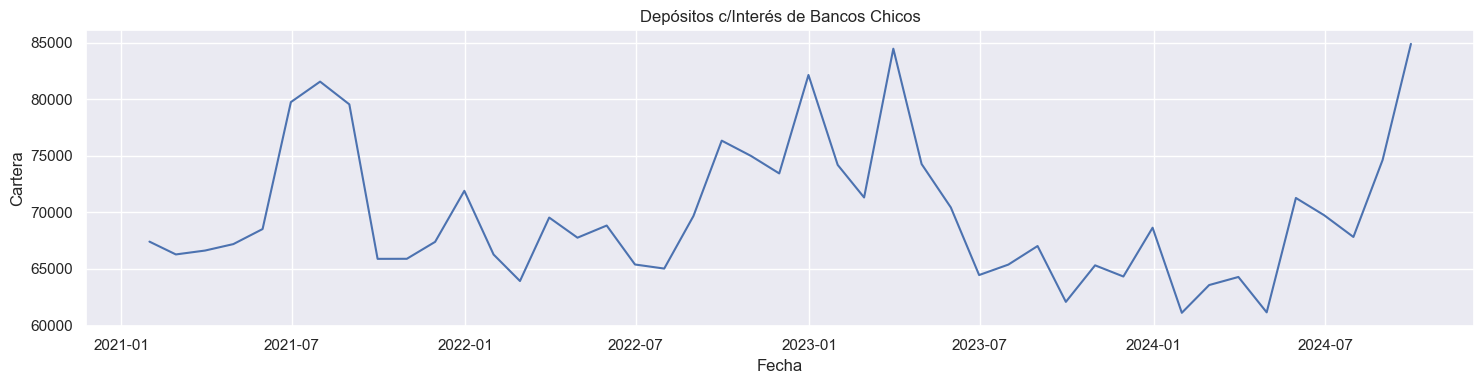

In [5]:
# Lienzo para visualizar la Serie de Tiempo
plt.figure(figsize = (15, 4), dpi = 100)
sns.lineplot(x = "FECHA", y = "y", data = data)
plt.xlabel("Fecha")
plt.ylabel("Cartera")
plt.title("Depósitos c/Interés de Bancos Chicos")

plt.grid(True)
plt.tight_layout()
plt.show()

Visualmente se puede observar un cambio de nivel a partir de Mayo de 2021. La sospecha es que hay datos atípicos.

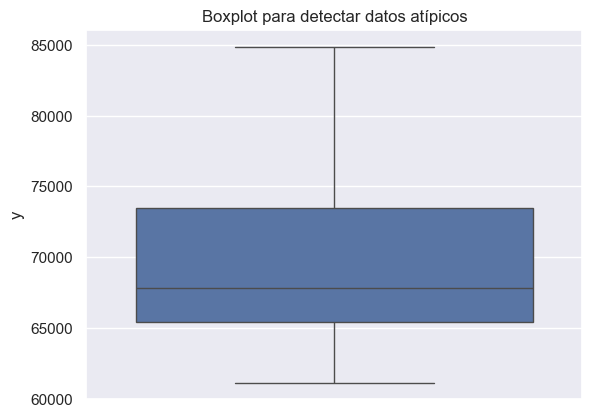

Outliers detectados: []


In [6]:
## Boxplot para visualizar datos atípicos
sns.boxplot(data["y"])
plt.title("Boxplot para detectar datos atípicos")
plt.show()

Q1 = data["y"].quantile(0.25)
Q3 = data["y"].quantile(0.75)
IQR = Q3 - Q1
df_atipicos = data[(data["y"] < Q1 - 1.5 * IQR) | (data["y"] > Q3 + 1.5 * IQR)]
df_fechas = df_atipicos["FECHA"]
print("Outliers detectados:", df_fechas.to_list())

**Eliminamos los datos atípicos que están al principio de la serie**, porque estos outliers iniciales pueden distorsionar significativamente los análisis y modelos predictivos.  Estos valores pueden ser producto de errores de medición o eventos no repetibles que no aportan información relevante para el análisis continuo. Por lo tanto, eliminarlos permite una representación más precisa y coherente de los datos, mejorando la calidad del modelo y la fiabilidad de las predicciones.

In [7]:
## Borramos datos atípícos 
data = data.drop(df_fechas.index)
data.head(5)

,FECHA,y
0,2021-01-31,67415.92
1,2021-02-28,66283.87
2,2021-03-31,66627.66
3,2021-04-30,67197.13
4,2021-05-31,68526.13


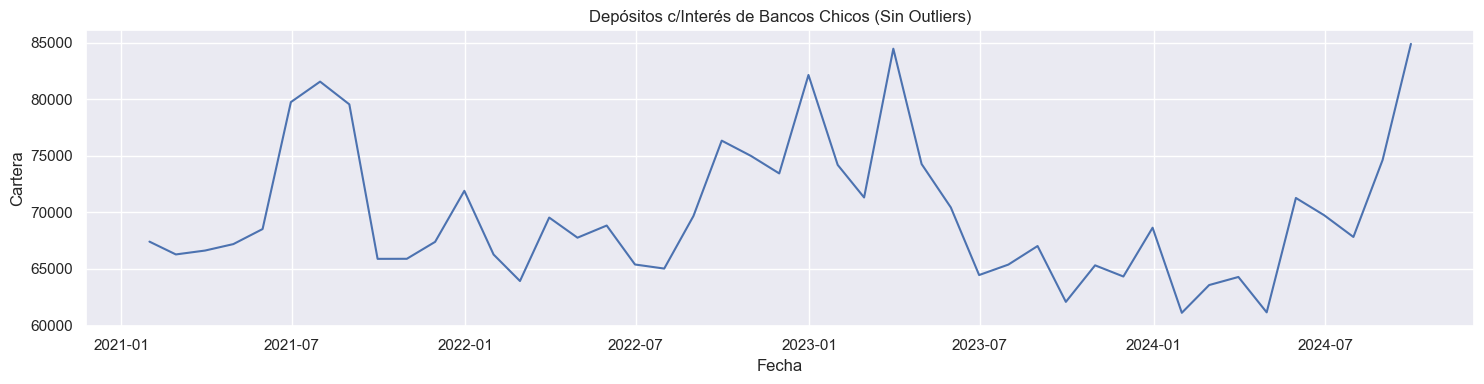

In [8]:
# Lienzo para visualizar la Serie de Tiempo
plt.figure(figsize = (15, 4), dpi = 100)
sns.lineplot(x = "FECHA", y = "y", data = data)
plt.xlabel("Fecha")
plt.ylabel("Cartera")
plt.title("Depósitos c/Interés de Bancos Chicos (Sin Outliers)")

plt.grid(True)
plt.tight_layout()
plt.show()

#### Análisis Descriptivo

In [9]:
data["Return"] = data["y"].pct_change() * 100
print(data["Return"].describe())

count    44.00
mean      0.82
std       7.83
min     -17.15
25%      -3.62
50%       0.26
75%       5.57
max      18.43
Name: Return, dtype: float64


## 1️⃣ Metodología Box-Jenkins

Análisis exploratorio:
1) La primera gráfica muestra la serie original.
2) La segunda gráfica muestra la tendencia de la serie. Al ser una curva creciente, se muestra que la serie tiene tendencia positiva (SERIE NO ESTACIONARIA)
3) La tercera gráfica muestra la estacionalidad de la serie, la cual SÍ muestra un patrón estacional
4) La cuarta gráfica muestra los residuos de la serie, la cual muestra un patrón

In [10]:
## Obtener Datos
data_arima = data.copy()

Prueba de estacionariedad mediante el test de Dickey-Fuller

In [11]:
test_DF = adfuller(data_arima["y"], autolag = "AIC")
print(f"Estadístico ADF: {test_DF[0]}")
print(f"p-value: {test_DF[1]}")
if test_DF[1] <= 0.05:
    print("La serie SÍ es estacionaria")
else:
    print("La serie NO es estacionaria")

Estadístico ADF: -2.8267559308080767
p-value: 0.05455234335734514
La serie NO es estacionaria


Dado que la serie SÍ es estacionaria en media, vamos a continuar con la Metodología

Aunque la prueba de estacionariedad de Dickey-Fuller indica que la serie es estacionaria, el análisis de la Función de Autocorrelación (ACF) sugiere lo contrario, ya que la autocorrelación se reduce lentamente en lugar de truncarse rápidamente. Por esta razón, se aplicará una diferenciación adicional para garantizar la estacionariedad del modelo.

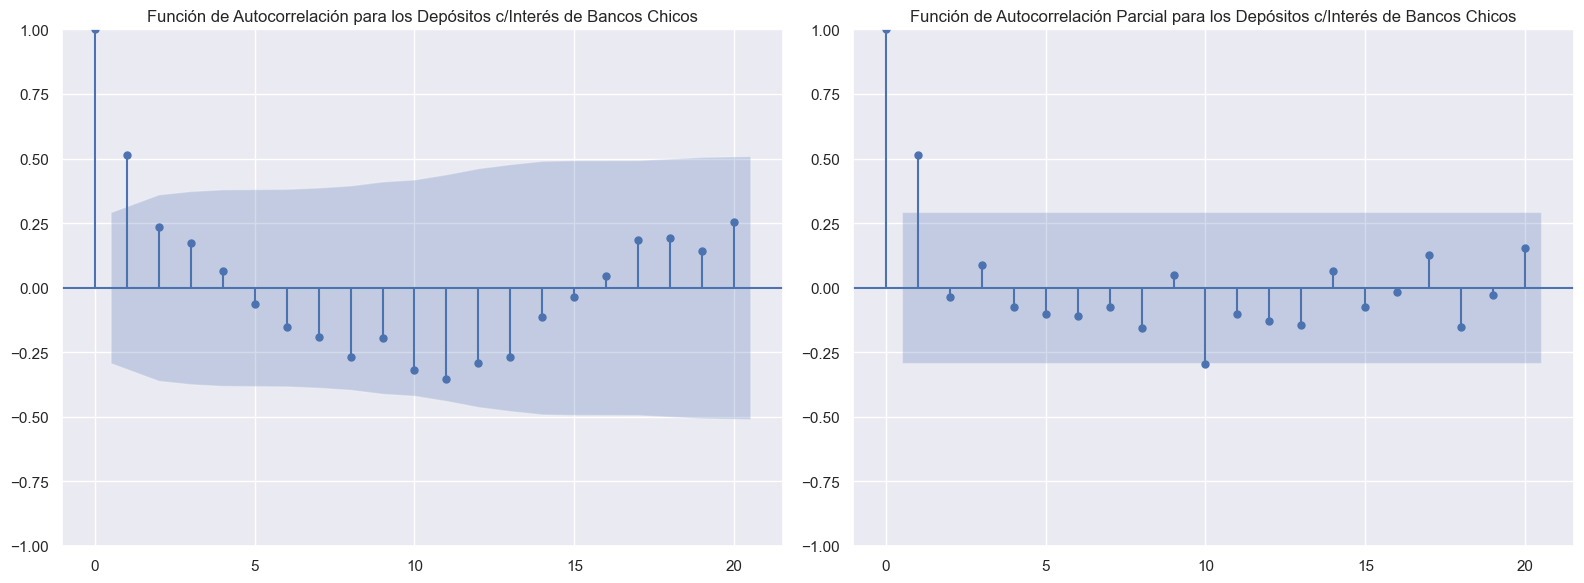

In [12]:
# Asegúrate de que no haya valores NaN en la columna antes de graficar
serie = data_arima["y"]

# Crear subplots para ACF y PACF
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Gráfico de la ACF
plot_acf(serie, lags = 20, ax = axes[0])
axes[0].set_title("Función de Autocorrelación para los Depósitos c/Interés de Bancos Chicos")

# Gráfico de la PACF
plot_pacf(serie, lags = 20, ax = axes[1])
axes[1].set_title("Función de Autocorrelación Parcial para los Depósitos c/Interés de Bancos Chicos")

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [13]:
data_arima["diff_y"] = data_arima["y"].diff().dropna()
data_arima = data_arima.dropna()
data_arima.head()

,FECHA,y,Return,diff_y
1,2021-02-28,66283.87,-1.68,-1132.05
2,2021-03-31,66627.66,0.52,343.80
3,2021-04-30,67197.13,0.85,569.47
4,2021-05-31,68526.13,1.98,1329.00
5,2021-06-30,79735.51,16.36,11209.38


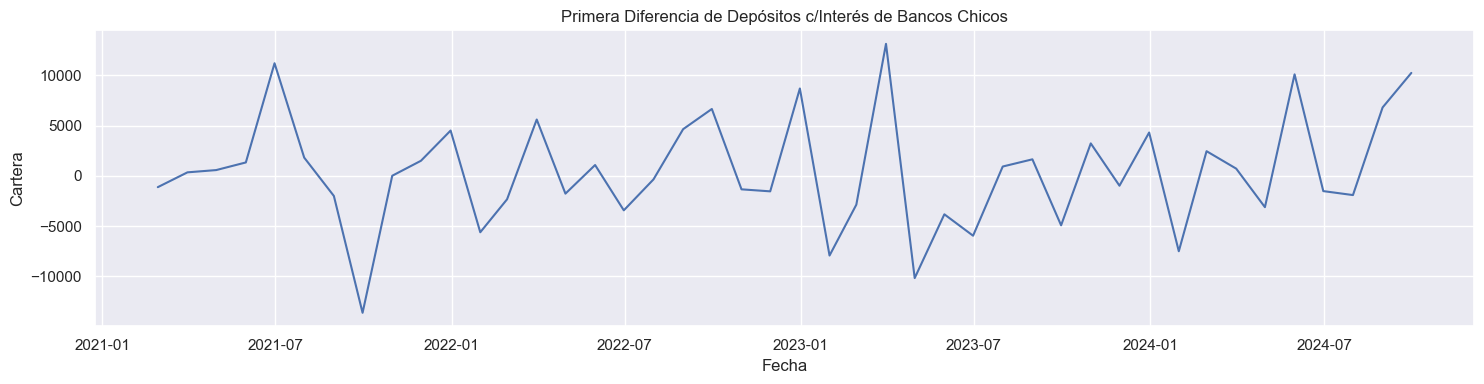

In [14]:
# Lienzo para visualizar la Serie de Tiempo
plt.figure(figsize = (15, 4), dpi = 100)
sns.lineplot(x = "FECHA", y = "diff_y", data = data_arima)
plt.xlabel("Fecha")
plt.ylabel("Cartera")
plt.title("Primera Diferencia de Depósitos c/Interés de Bancos Chicos")

plt.grid(True)
plt.tight_layout()
plt.show()

La serie ya muestra buen comportamiento. Por lo cual, se continua con la estimación de los parámetros del Modelo $$ARIMA (p, d, q)$$

#### Análisis de Funciones de Autocorrelación y Autocorrelación Parcial

El análisis de la Función de Autocorrelación (ACF) y la Función de Autocorrelación Parcial (PACF) revela que ambas funciones se truncan en el rezago 1, lo que indica que la serie presenta una estructura autoregresiva y de medias móviles de primer orden.

Dado este comportamiento, se explorarán modelos ARIMA con diferentes configuraciones de parámetros para evaluar cuál se ajusta mejor a la serie de tiempo:

* **ARIMA(1,1,1)**: Considera tanto un término autoregresivo ($p=1$) como un término de media móvil ($q=1$)
* **ARIMA(0,1,1)**: Modelo basado únicamente en la componente de media móvil ($q=1$), útil si la serie sigue un comportamiento de ruido blanco tras la diferenciación.
* **ARIMA(1,1,0)**: Modelo basado únicamente en la componente autoregresivo ($p=1$), útil si la serie tiene memoria de sus valores pasados sin la necesidad de un término MA.

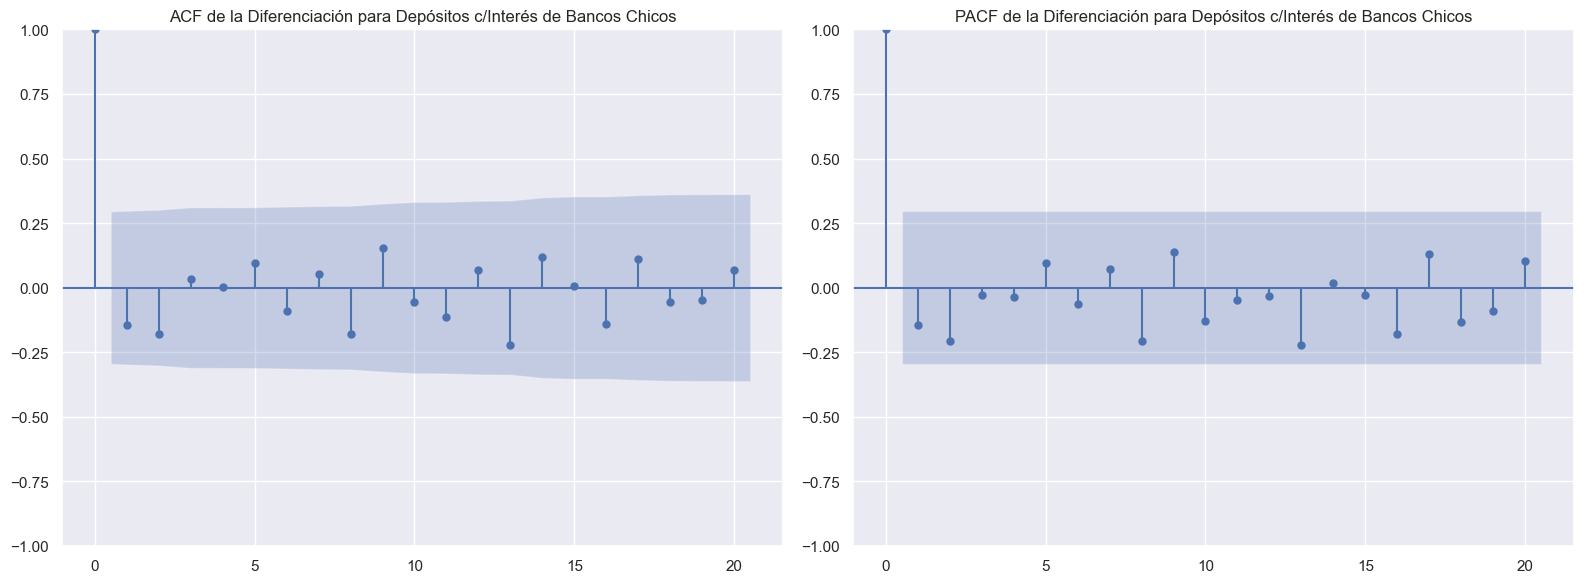

In [15]:
# Asegúrate de que no haya valores NaN en la columna antes de graficar
serie = data_arima["diff_y"]

# Crear subplots para ACF y PACF
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Gráfico de la ACF
plot_acf(serie, lags = 20, ax = axes[0])
axes[0].set_title("ACF de la Diferenciación para Depósitos c/Interés de Bancos Chicos")

# Gráfico de la PACF
plot_pacf(serie, lags = 20, ax = axes[1])
axes[1].set_title("PACF de la Diferenciación para Depósitos c/Interés de Bancos Chicos")

# Mostrar las gráficas
plt.tight_layout()
plt.show()

#### Construcción de modelos ARIMA y la significancia de los parámetros $p$, $d$ y $q$
$$p-value=\begin{cases} \text{Significativo} & \text{if } p-value \geq 0.05 \\ \text{No Significativo} & \text{En otro caso} \end{cases}$$

### Modelo 1: ARIMA(1,1,1)




Se analiza la significancia de los parámetros por medio de los p-values:

* **ar.L1**: p-value = 0.000 -> Significativo
* **ma.L1**: p-value = 0.000 -> Significativo

Por lo tanto, se acepta este modelo ✅

In [16]:
# Modelo 1
modelo = ARIMA(data_arima["y"], order = (1, 1, 1))
mod_salida = modelo.fit()
print(mod_salida.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -432.263
Date:                Fri, 14 Mar 2025   AIC                            870.526
Time:                        01:15:53   BIC                            875.810
Sample:                             0   HQIC                           872.475
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1900      3.721      0.051      0.959      -7.102       7.482
ma.L1         -0.2277      3.728     -0.061      0.951      -7.534       7.078
sigma2      2.976e+07    5.8e-07   5.13e+13      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Modelo 2: ARIMA(1,1,0)

Se analiza la significancia de los parámetros por medio de los p-values:

* **ar.L1**: p-value = 0.624  -> NO Significativo

Por lo tanto, se descarta este modelo ❌

In [17]:
# Modelo 2
modelo = ARIMA(data_arima["y"], order = (1, 1, 0))
mod_salida = modelo.fit()
print(mod_salida.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -432.261
Date:                Fri, 14 Mar 2025   AIC                            868.522
Time:                        01:15:53   BIC                            872.045
Sample:                             0   HQIC                           869.821
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0319      0.128     -0.249      0.804      -0.284       0.220
sigma2      3.172e+07   3.79e-10   8.37e+16      0.000    3.17e+07    3.17e+07
Ljung-Box (L1) (Q):                   0.69   Jarque-

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Modelo 3: ARIMA(0,1,1)

Se analiza la significancia de los parámetros por medio de los p-values:

* **ma.L1**: p-value = 0.697  -> NO Significativo

Por lo tanto, se descarta este modelo ❌

In [18]:
# Modelo 3
modelo = ARIMA(data_arima["y"], order = (0, 1, 1))
mod_salida = modelo.fit()
print(mod_salida.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -432.273
Date:                Fri, 14 Mar 2025   AIC                            868.545
Time:                        01:15:53   BIC                            872.068
Sample:                             0   HQIC                           869.844
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0348      0.120     -0.290      0.771      -0.270       0.200
sigma2      3.024e+07   3.85e-10   7.86e+16      0.000    3.02e+07    3.02e+07
Ljung-Box (L1) (Q):                   0.67   Jarque-

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Selección del Modelo

Tras la evaluación de los modelos propuestos **ARIMA(1,1,1), ARIMA(0,1,1) y ARIMA(1,1,0)**, se analizó la significancia estadística de sus parámetros mediante la inspección de los p-values de sus coeficientes. De acuerdo con los resultados obtenidos, el modelo **ARIMA(1,1,1)** presenta coeficientes estadísticamente significativos, ya que sus p-values son menores a 0.05, lo que indica que los términos autoregresivos ($p=1$) y de media móvil ($q=1$) contribuyen significativamente a la explicación de la serie de tiempo.

Dado que la significancia de los parámetros es un criterio fundamental para garantizar la robustez del modelo, y que este ha demostrado ser adecuado tanto en términos de ajuste como de capacidad explicativa, se selecciona ARIMA(1,1,1) como el modelo final para la generación de pronósticos (Forecast).

In [19]:
# Modelo Seleccionado
modelo = ARIMA(data_arima["y"], order = (1, 1, 1))
mod_salida = modelo.fit()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Evaluación del Modelo

**Análisis de Residuales**

Al tener un p-value = 1 > 0.05, significa que **NO hay Ruido Blanco**

En el test de Normalidad, se obtiene un p-value =  2.09246039e-10] < 0.05, lo que significa que **SÍ existe Normalidad en los Residuales**

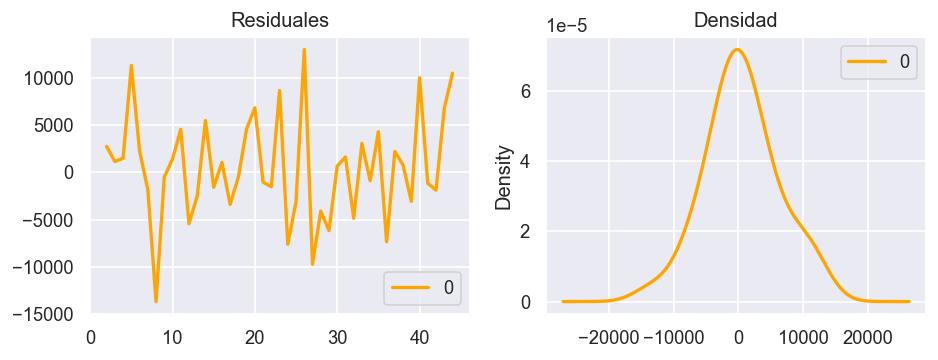

    lb_stat  lb_pvalue
10     2.89       0.98
NormaltestResult(statistic=array([0.371238]), pvalue=array([0.83058999]))


In [20]:
plt.rcParams.update({"figure.figsize": (9, 3), "figure.dpi": 120})

residuals = pd.DataFrame(mod_salida.resid)[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = "Residuales", ax = ax[0], color = "orange", lw = 2)
residuals.plot(kind = "kde", title = "Densidad", ax = ax[1], color = "orange", lw = 2)
plt.show()

print(sm.stats.acorr_ljungbox(mod_salida.resid, lags = [10], return_df = True))
print(normaltest(residuals))

### Efectividad del Modelo con Base en el $R^2$
 

El coeficiente de determinación $R^2$ obtenido para el modelo **ARIMA(1,1,1)** es del **96.34%**, lo que indica que el modelo es altamente efectivo para explicar la variabilidad de la serie de tiempo. Este valor sugiere que el modelo captura de manera precisa la estructura de los datos, minimizando el error y proporcionando estimaciones confiables.

Un $R^2$ elevado implica que el modelo ajusta correctamente la serie y que la relación entre los valores observados y los valores ajustados es consistente. Además, la comparación con modelos alternativos confirma que ARIMA(1,1,1) logra una mejor representación de los patrones subyacentes en los datos, lo que refuerza su validez para realizar pronósticos futuros.

Por lo tanto, debido a su alto nivel de ajuste y capacidad predictiva, se concluye que ARIMA(1,1,1) es un modelo adecuado para la generación de Forecasts, asegurando que las proyecciones sean representativas de la dinámica de la serie analizada.

In [21]:
# Predicciones dentro de la muestra (fitted values)
predicciones_in_sample = mod_salida.fittedvalues[1:]

# Excluir el primer valor por diferenciación
reales = data_arima["y"].iloc[1:]

# Calcular R² in-sample
r2_in_sample = r2_score(reales, predicciones_in_sample)
print(f"R² dentro de la muestra (in-sample): {r2_in_sample}")

R² dentro de la muestra (in-sample): 0.16215899242106346


### Pronósticos

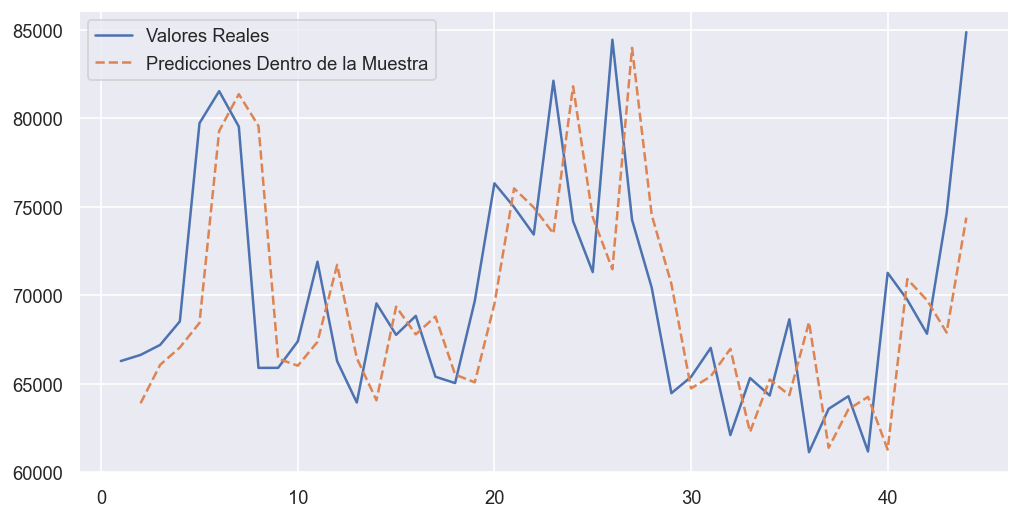

In [22]:
## Pronóstico dentro de la serie
in_sample_forecast = mod_salida.fittedvalues[1:]

plt.figure(figsize=(10,5))
plt.plot(data_arima["y"], label = "Valores Reales")
plt.plot(in_sample_forecast, label = "Predicciones Dentro de la Muestra", linestyle = "--")
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


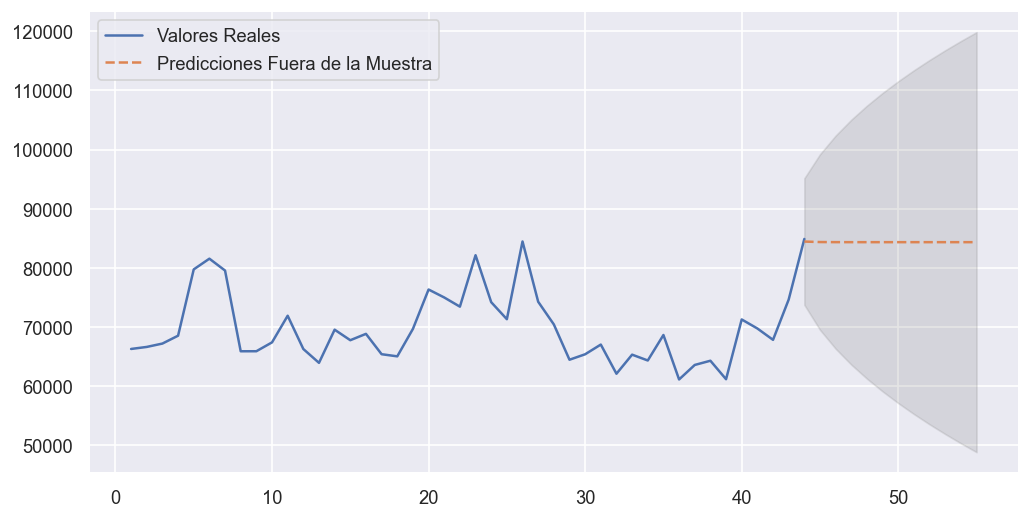

In [23]:
## Pronóstico fuera de la serie
num_periods = 12

# Realizar la predicción fuera de la muestra
out_of_sample_forecast = mod_salida.get_forecast(steps = num_periods)

# Obtén las predicciones en forma de serie temporal
forecast_values = out_of_sample_forecast.predicted_mean

# Obtén el intervalo de confianza de las predicciones
conf_int = out_of_sample_forecast.conf_int()

# Visualización de la predicción fuera de la muestra
plt.figure(figsize = (10, 5))
plt.plot(data_arima["y"], label = "Valores Reales")
plt.plot(forecast_values, label = "Predicciones Fuera de la Muestra", linestyle = "--")
plt.fill_between (forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color = "gray", alpha = 0.2)
plt.legend()
plt.show()

## 2️⃣ Predicciones con Suavizamiento Exponencial Holt-Winters

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


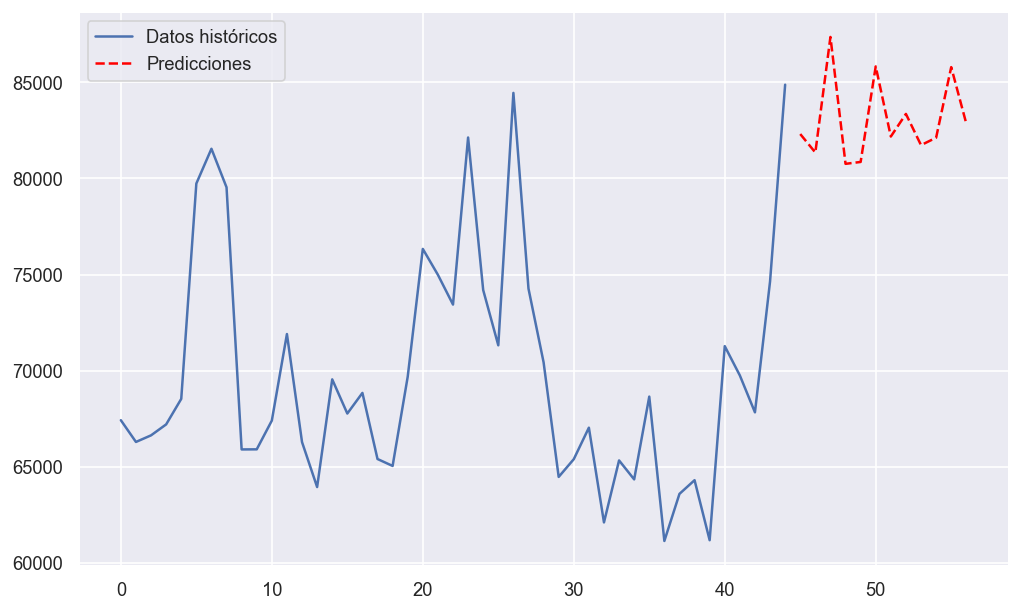

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ajustar el modelo
modelo = ExponentialSmoothing(
    data['y'],
    seasonal='add',  # Cambia a 'mul' si la estacionalidad es multiplicativa
    seasonal_periods=12  # Periodo estacional (ejemplo: 12 para datos mensuales)
)
modelo_ajustado = modelo.fit()

# Predecir
predicciones = modelo_ajustado.forecast(12)  # Predecir los próximos 12 períodos

# Visualizar predicciones
data['y'].plot(label='Datos históricos', figsize=(10, 6))
predicciones.plot(label='Predicciones', linestyle='--', color='red')
plt.legend()
plt.show()

In [25]:
predicciones

45   82312.08
46   81349.95
47   87365.72
48   80761.52
49   80859.36
50   85831.50
51   82182.26
52   83359.25
53   81735.12
54   82122.16
55   85794.79
56   82855.13
dtype: float64

## 3️⃣ Predicciones con XGBoost Regressor

In [26]:
data_xgboost = data.copy()

# Número de rezagos como variables predictoras
lags = 5
for i in range(1, lags + 1):
    data_xgboost[f"lag_{i}"] = data_xgboost["y"].shift(i)

data_xgboost = data_xgboost.dropna().reset_index(drop=True)

data_xgboost.head()

,FECHA,y,Return,lag_1,lag_2,lag_3,lag_4,lag_5
0,2021-06-30,79735.51,16.36,68526.13,67197.13,66627.66,66283.87,67415.92
1,2021-07-31,81545.91,2.27,79735.51,68526.13,67197.13,66627.66,66283.87
2,2021-08-31,79538.80,-2.46,81545.91,79735.51,68526.13,67197.13,66627.66
3,2021-09-30,65894.26,-17.15,79538.80,81545.91,79735.51,68526.13,67197.13
4,2021-10-31,65899.15,0.01,65894.26,79538.80,81545.91,79735.51,68526.13


/var/folders/ky/14b0x59j3f72jxqbnlcm03ww0000gn/T/ipykernel_25685/1799816305.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=test["FECHA"].iloc[-1], periods=n_forecast + 1, freq="M")[1:]


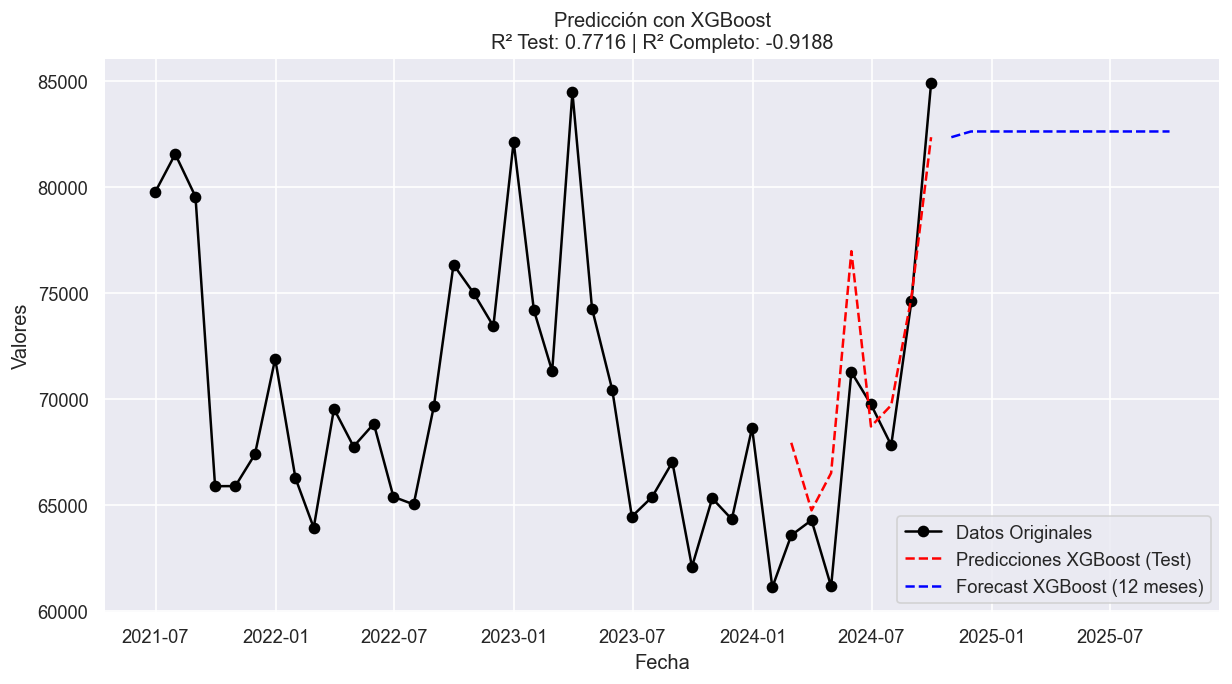

R² en Test: 0.7716
R² en toda la serie: -0.9188


In [27]:
data_xgboost = data.copy()

# Número de rezagos como variables predictoras
lags = 5
for i in range(1, lags + 1):
    data_xgboost[f"lag_{i}"] = data_xgboost["y"].shift(i)

# Eliminar valores NaN generados por los lags
data_xgboost = data_xgboost.dropna().reset_index(drop=True)

# División de conjuntos Train y Test
train_size = int(len(data_xgboost) * 0.8)  # 80% para entrenamiento
train, test = data_xgboost.iloc[:train_size], data_xgboost.iloc[train_size:]

# Creación de conjuntos de Entrenamiento y Pruebas
X_train, y_train = train.drop(columns = ["FECHA", "y"]), train["y"]
X_test, y_test = test.drop(columns = ["FECHA", "y"]), test["y"]

# Entrenamiento de Modelo
modelo_xgb = XGBRegressor(n_estimators = 50, learning_rate = 0.2, objective = "reg:squarederror")
modelo_xgb.fit(X_train, y_train)

# Predicciones dentro de la Serie
pred_train = modelo_xgb.predict(X_train)
pred_test = modelo_xgb.predict(X_test)
pred_series = np.concatenate([pred_train, pred_test])

min_length = min(len(data_xgboost["y"].iloc[lags:]), len(pred_series))
y_real = data_xgboost["y"].iloc[lags:lags+min_length].values
pred_series = pred_series[:min_length]
r2_test = r2_score(y_test, pred_test)
r2_completo = r2_score(y_real, pred_series)

# Predicciones fuera de la Serie (Rolling Forecast)
n_forecast = 12

last_known_data = test.iloc[-1:].copy()

future_predictions = []

for i in range(n_forecast):
    X_input = last_known_data.drop(columns=["FECHA", "y"]).values  # Eliminar la columna de fecha para predecir
    next_pred = modelo_xgb.predict(X_input)[0]  # Hacer la predicción
    future_predictions.append(next_pred)  # Guardar el valor predicho

    # Actualizar los lags con la nueva predicción
    for j in range(lags, 0, -1):
        last_known_data[f"lag_{j}"] = last_known_data[f"lag_{j-1}"] if j > 1 else next_pred

future_dates = pd.date_range(start=test["FECHA"].iloc[-1], periods=n_forecast + 1, freq="M")[1:]
df_future = pd.DataFrame({"FECHA": future_dates, "Predicciones_Futuras": future_predictions})

# Gráficos de la Serie de Tiempo
plt.figure(figsize=(12,6))

plt.plot(data_xgboost["FECHA"], data_xgboost["y"], label="Datos Originales", marker="o", color="black")

plt.plot(test["FECHA"], pred_test, label="Predicciones XGBoost (Test)", linestyle="dashed", color="red")

plt.plot(df_future["FECHA"], df_future["Predicciones_Futuras"], label="Forecast XGBoost (12 meses)", linestyle="dashed", color="blue")

plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title(f"Predicción con XGBoost\nR² Test: {r2_test:.4f} | R² Completo: {r2_completo:.4f}")
plt.legend()
plt.show()

df_predicciones = data_xgboost.iloc[lags:lags+min_length].copy()
df_predicciones["Predicciones_XGBoost"] = pred_series

print(f"R² en Test: {r2_test:.4f}")
print(f"R² en toda la serie: {r2_completo:.4f}")

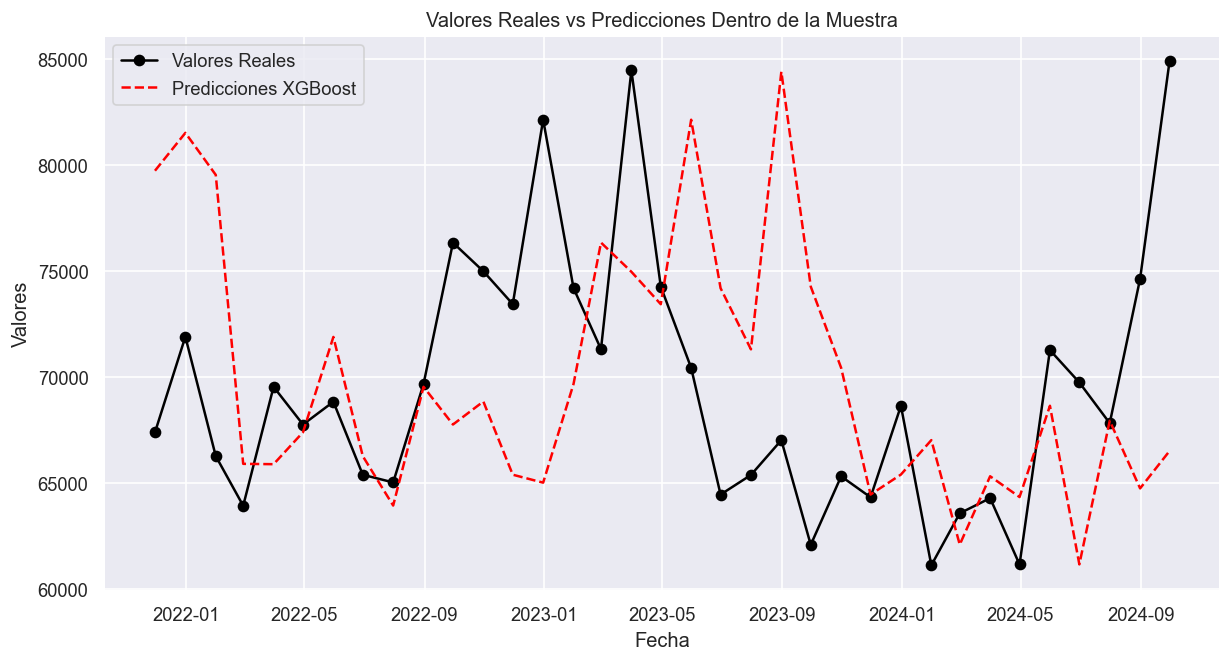

In [28]:
plt.figure(figsize=(12,6))
plt.plot(df_predicciones["FECHA"], df_predicciones["y"], label="Valores Reales", marker="o", color="black")
plt.plot(df_predicciones["FECHA"], df_predicciones["Predicciones_XGBoost"], label="Predicciones XGBoost", linestyle="dashed", color="red")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Valores Reales vs Predicciones Dentro de la Muestra")
plt.legend()
plt.show()

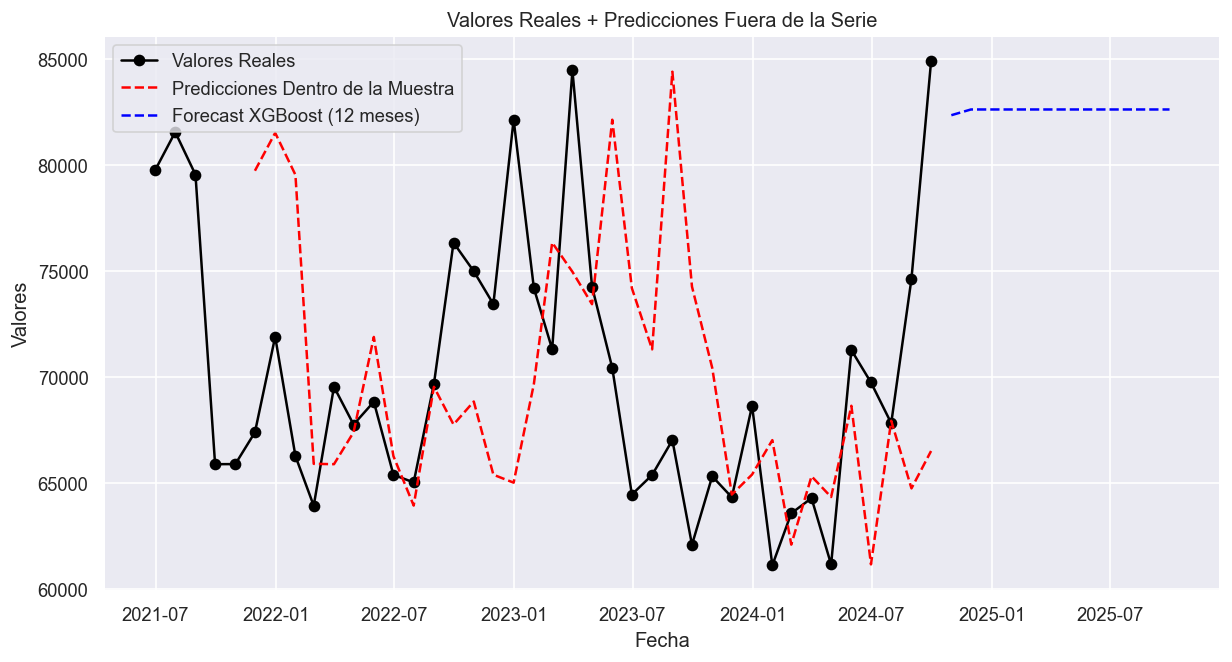

In [29]:
plt.figure(figsize=(12,6))
plt.plot(data_xgboost["FECHA"], data_xgboost["y"], label="Valores Reales", marker="o", color="black")
plt.plot(df_predicciones["FECHA"], df_predicciones["Predicciones_XGBoost"], label="Predicciones Dentro de la Muestra", linestyle="dashed", color="red")
plt.plot(df_future["FECHA"], df_future["Predicciones_Futuras"], label="Forecast XGBoost (12 meses)", linestyle="dashed", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Valores Reales + Predicciones Fuera de la Serie")
plt.legend()
plt.show()